In [3]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import seaborn as sns
sns.set_style('whitegrid')
import os
from scipy import sparse
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import random

# Data Analysis

## Preprocessing

In [298]:
start = datetime.now()
if not os.path.isfile('/Users/rj/Downloads/data.csv'):
    data = open('/Users/rj/Downloads/data.csv', mode='w')
    row = list()
    files=['/Users/rj/Downloads/netflix-prize-data/combined_data_1.txt','/Users/rj/Downloads/netflix-prize-data/combined_data_2.txt', 
           '/Users/rj/Downloads/netflix-prize-data/combined_data_3.txt', '/Users/rj/Downloads/netflix-prize-data/combined_data_4.txt']
    for file in files:
        with open(file) as f:
            for line in f: 
                del row[:]
                line = line.strip()
                if line.endswith(':'):
                    movie_id = line.replace(':', '')
                else:
                    row = [x for x in line.split(',')]
                    row.insert(0, movie_id)
                    data.write(','.join(row))
                    data.write('\n')
    data.close()

In [299]:
# /Users/rj/Downloads/netflix-prize-data
df = pd.read_csv('/Users/rj/Downloads/data.csv', sep=',', names=['movie', 'user','rating','date'])
df.date = pd.to_datetime(df.date)
df.sort_values(by='date', inplace=True)

In [300]:
print("No of Nan values : ", sum(df.isnull().any()))

No of Nan values :  0


In [301]:
#duplicates removal
dup_bool = df.duplicated(['movie','user','rating'])
dups = sum(dup_bool)
print("There are {} duplicate ".format(dups))

There are 0 duplicate 


In [302]:
#Basic Statistics
print("\nTotal no of ratings :",df.shape[0])
print("Total No of Users   :", len(np.unique(df.user)))
print("Total No of movies  :", len(np.unique(df.movie)))


Total no of ratings : 100480507
Total No of Users   : 480189
Total No of movies  : 17770


In [11]:
#creating test and train datasets 
if not os.path.isfile('/Users/rj/Downloads/netflix-prize-data/train.csv'):
    df.iloc[:int(df.shape[0]*0.80)].to_csv("/Users/rj/Downloads/netflix-prize-data/train.csv", index=False)

if not os.path.isfile('/Users/rj/Downloads/netflix-prize-data/test.csv'):
    df.iloc[int(df.shape[0]*0.80):].to_csv("/Users/rj/Downloads/netflix-prize-data/test.csv", index=False)

train_df = pd.read_csv("/Users/rj/Downloads/netflix-prize-data/train.csv", parse_dates=['date'])
test_df = pd.read_csv("/Users/rj/Downloads/netflix-prize-data/test.csv")

In [308]:
# Analysis on the Ratings given by user
rated_movies_per_user = train_df.groupby(by='user')['rating'].count().sort_values(ascending=False)

rated_movies_per_user.head(10)

user
305344     17112
2439493    15896
387418     15402
1639792     9767
1461435     9447
1314869     8964
1932594     8577
2606799     8318
1114324     7898
2056022     7554
Name: rating, dtype: int64

# Creating sparse matrix

In [312]:
# Creating sparse matrix from train data frame

start = datetime.now()
if os.path.isfile('train_SM.npz'):
    train_SM = sparse.load_npz('train_SM.npz')
else: 
    train_SM = sparse.csr_matrix((train_df.rating.values, (train_df.user.values,train_df.movie.values)),)
    
    print('shape : (user, movie) : ',train_SM.shape)
    sparse.save_npz("train_SM.npz", train_SM)

shape : (user, movie) :  (2649430, 17771)


In [314]:
us,mv = train_SM.shape
elem = train_SM.count_nonzero()

print("Sparsity Of Training matrix : {} % ".format(  (1-(elem/(us*mv))) * 100) )

Sparsity Of Training matrix : 99.8292709259195 % 


In [316]:
# Creating sparse matrix from test data frame

start = datetime.now()
if os.path.isfile('test_SM.npz'):
    test_SM = sparse.load_npz('test_SM.npz')
else: 
    test_SM = sparse.csr_matrix((test_df.rating.values, (test_df.user.values,test_df.movie.values)))
    
    print('shape is : (user, movie) : ',test_SM.shape)
    sparse.save_npz("test_SM.npz", test_SM)
    
print(datetime.now() - start)

shape :  (2649430, 17771)


In [25]:
us,mv = test_SM.shape
elem = test_SM.count_nonzero()

print("Sparsity Of Test matrix : {} % ".format(  (1-(elem/(us*mv))) * 100) )

Sparsity Of Test matrix : 99.95731772988694 % 


In [10]:
def get_average_ratings(sparse_matrix, of_users):
    
    ax = 1 if of_users else 0 
    sum_of_ratings = sparse_matrix.sum(axis=ax).A1
    is_rated = sparse_matrix!=0
    no_of_ratings = is_rated.sum(axis=ax).A1
    
    u,m = sparse_matrix.shape
    average_ratings = { i : sum_of_ratings[i]/no_of_ratings[i]
                                 for i in range(u if of_users else m) 
                                    if no_of_ratings[i] !=0}

    return average_ratings

In [11]:
train_averages = dict()
train_global_average = train_SM.sum()/train_SM.count_nonzero()
train_averages['global'] = train_global_average
train_averages

{'global': 3.582890686321557}

In [20]:
train_averages['user'] = get_average_ratings(train_SM, of_users=True)
print('\nAverage rating of user 247 :',train_averages['user'][247])


Average rating of user 247 : 4.019230769230769


In [19]:
train_averages['user']

{6: 3.5160550458715596,
 7: 3.992957746478873,
 10: 3.3781094527363185,
 25: 3.5,
 33: 3.787878787878788,
 42: 3.9322033898305087,
 59: 3.698717948717949,
 79: 3.5559947299077734,
 83: 4.0,
 87: 3.544642857142857,
 94: 2.8125,
 97: 3.182377049180328,
 131: 4.0,
 134: 4.703081232492997,
 142: 3.45,
 149: 4.25,
 158: 3.625,
 168: 4.208333333333333,
 169: 3.738562091503268,
 178: 3.0,
 183: 3.7096774193548385,
 188: 3.4456066945606696,
 189: 3.0,
 192: 3.522222222222222,
 195: 3.689655172413793,
 199: 3.974747474747475,
 201: 3.605714285714286,
 242: 2.8392857142857144,
 247: 4.019230769230769,
 248: 3.6511627906976742,
 261: 2.769230769230769,
 265: 3.680297397769517,
 266: 4.102222222222222,
 267: 3.325,
 268: 4.008,
 283: 3.4794816414686824,
 291: 3.4745762711864407,
 296: 3.789473684210526,
 298: 3.8052805280528053,
 299: 3.5555555555555554,
 301: 4.05524861878453,
 302: 3.212,
 304: 3.8051948051948052,
 305: 4.096551724137931,
 307: 3.6486486486486487,
 308: 3.4285714285714284,
 310:

In [21]:
train_averages['movie'] =  get_average_ratings(train_SM, of_users=False)
print('\n AVerage rating of movie 20 :',train_averages['movie'][20])


 AVerage rating of movie 20 : 3.119565217391304


# Cold Start problem

In [32]:
# Cold Start problem with Users

total_users = len(np.unique(df.user))
users_train = len(train_averages['user'])
new_users = total_users - users_train

print('\nTotal number of Users  :', total_users)
print('\nNumber of Users in Train data :', users_train)
print("\nNo of Users that didn't appear in train data: {}({} %) \n ".format(new_users,np.round((new_users/total_users)*100, 2)))


Total number of Users  : 480189

Number of Users in Train data : 405041

No of Users that didn't appear in train data: 75148(15.65 %) 
 


In [33]:
# Cold Start problem with Movies

total_movies = len(np.unique(df.movie))
movies_train = len(train_averages['movie'])
new_movies = total_movies - movies_train

print('\nTotal number of Movies  :', total_movies)
print('\nNumber of Users in Train data :', movies_train)
print("\nNo of Movies that didn't appear in train data: {}({} %) \n ".format(new_movies,np.round((new_movies/total_movies)*100, 2)))


Total number of Movies  : 17770

Number of Users in Train data : 17424

No of Movies that didn't appear in train data: 346(1.95 %) 
 


# Computing Similarity matrices

In [34]:
# User user similarity matrix

In [30]:
from sklearn.metrics.pairwise import cosine_similarity


def compute_user_similarity(sparse_matrix, compute_for_few=False, top = 100, verbose=False, verb_for_n_rows = 20,
                            draw_time_taken=True):
    no_of_users, _ = sparse_matrix.shape
    row_ind, col_ind = sparse_matrix.nonzero()
    row_ind = sorted(set(row_ind)) 
    time_taken = list() 
    
    rows, cols, data = list(), list(), list()
    if verbose: print("Computing top",top,"similarities for each user..")
    
    start = datetime.now()
    temp = 0
    
    for row in row_ind[:top] if compute_for_few else row_ind:
        temp = temp+1
        prev = datetime.now()
        
        sim = cosine_similarity(sparse_matrix.getrow(row), sparse_matrix).ravel()
        top_sim_ind = sim.argsort()[-top:]
        top_sim_val = sim[top_sim_ind]
        
        rows.extend([row]*top)
        cols.extend(top_sim_ind)
        data.extend(top_sim_val)
        time_taken.append(datetime.now().timestamp() - prev.timestamp())
        if verbose:
            if temp%verb_for_n_rows == 0:
                print("computing done for {} users [  time elapsed : {}  ]"
                      .format(temp, datetime.now()-start))
            
        
    if verbose: print('Creating Sparse matrix from the computed similarities')
    
    if draw_time_taken:
        plt.plot(time_taken, label = 'time taken for each user')
        plt.plot(np.cumsum(time_taken), label='Total time')
        plt.legend(loc='best')
        plt.xlabel('User')
        plt.ylabel('Time (seconds)')
        plt.show()
        
    return sparse.csr_matrix((data, (rows, cols)), shape=(no_of_users, no_of_users)), time_taken

Computing top 100 similarities for each user..
computing done for 20 users [  time elapsed : 0:01:48.172058  ]
computing done for 40 users [  time elapsed : 0:03:40.763959  ]
computing done for 60 users [  time elapsed : 0:05:14.750727  ]
computing done for 80 users [  time elapsed : 0:07:04.214033  ]
computing done for 100 users [  time elapsed : 0:08:50.496173  ]
Creating Sparse matrix from the computed similarities


<IPython.core.display.Javascript object>


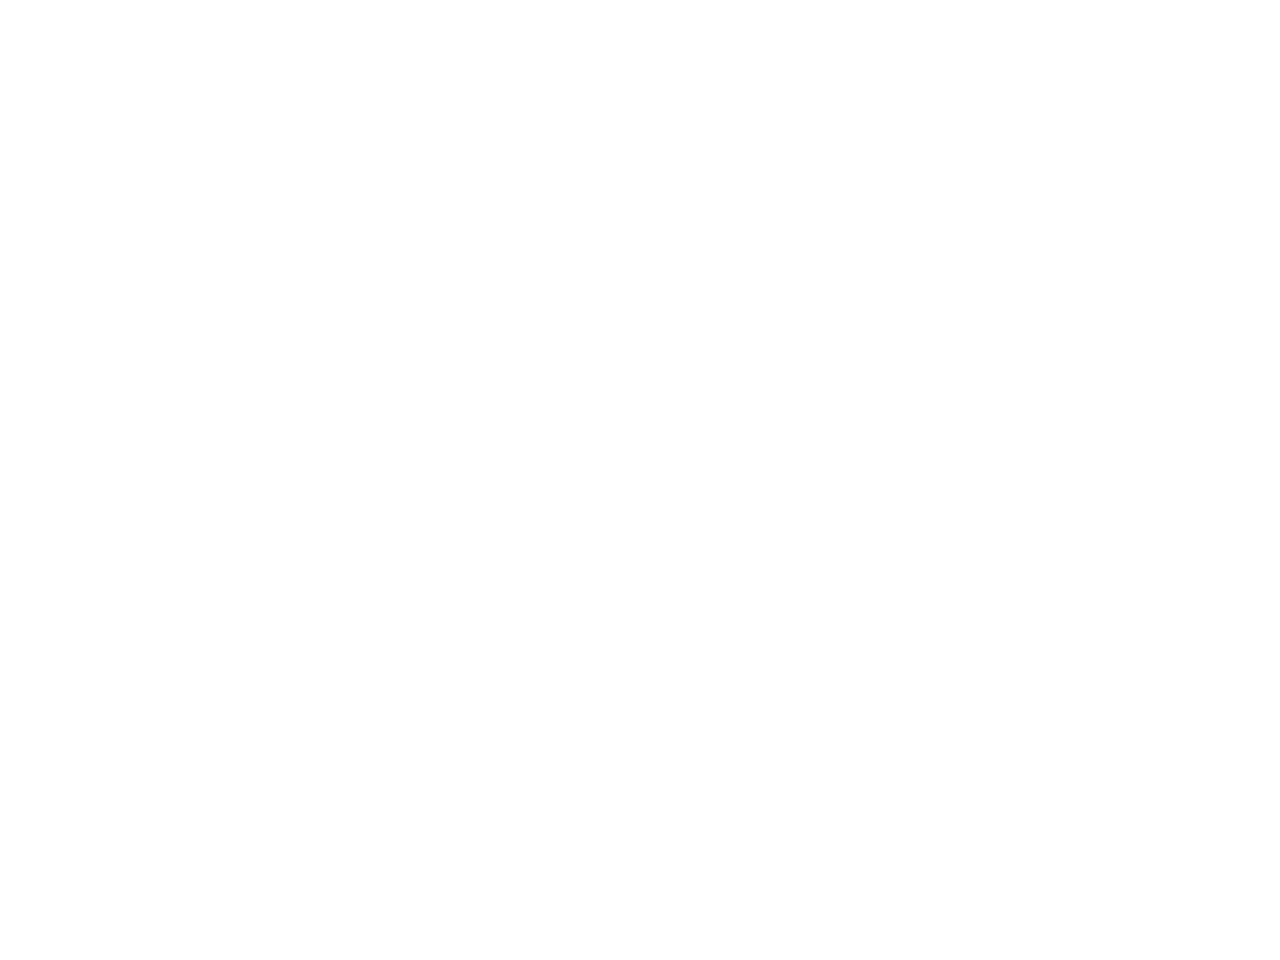

----------------------------------------------------------------------------------------------------
Time taken : 0:09:04.133283


In [36]:
start = datetime.now()
u_u_sim_sparse, _ = compute_user_similarity(train_SM, compute_for_few=True, top = 100,
                                                     verbose=True)

In [22]:
from datetime import datetime
from sklearn.decomposition import TruncatedSVD

start = datetime.now()

netflix_svd = TruncatedSVD(n_components=100, algorithm='randomized', random_state=15)
trunc_svd = netflix_svd.fit_transform(train_SM)

0:05:54.894720


In [23]:
expl_var = np.cumsum(netflix_svd.explained_variance_ratio_)

In [24]:
expl_var

array([0.23362135, 0.26270872, 0.28323418, 0.29936103, 0.31129667,
       0.32272449, 0.33168545, 0.33816688, 0.34421001, 0.34939129,
       0.35412811, 0.35790579, 0.36145969, 0.36481079, 0.36796535,
       0.3709693 , 0.37381048, 0.37654066, 0.37892266, 0.38128433,
       0.38355732, 0.38573246, 0.38787213, 0.3899668 , 0.39201512,
       0.39393493, 0.39577015, 0.39753909, 0.39924778, 0.40091934,
       0.402514  , 0.40408078, 0.40563178, 0.4071533 , 0.40864386,
       0.41009223, 0.41151649, 0.4129149 , 0.41428156, 0.41561932,
       0.41692423, 0.41818759, 0.41941408, 0.42062818, 0.42183339,
       0.42300936, 0.42417126, 0.42530364, 0.4264196 , 0.42752938,
       0.4286206 , 0.42968962, 0.43073842, 0.4317695 , 0.43279827,
       0.43380954, 0.43480725, 0.4357838 , 0.43675541, 0.43771242,
       0.43865584, 0.43959416, 0.44051303, 0.44142499, 0.44232835,
       0.44322288, 0.44410222, 0.4449794 , 0.44583546, 0.44668261,
       0.44752479, 0.44836456, 0.4491856 , 0.45000297, 0.45081

In [25]:
start = datetime.now()
trunc_matrix = train_SM.dot(netflix_svd.components_.T)

In [26]:
type(trunc_matrix), trunc_matrix.shape

(numpy.ndarray, (2649430, 100))

In [27]:
if not os.path.isfile('trunc_sparse_matrix.npz'):
    trunc_sparse_matrix = sparse.csr_matrix(trunc_matrix)
    sparse.save_npz('trunc_sparse_matrix', trunc_sparse_matrix)
else:
    trunc_sparse_matrix = sparse.load_npz('trunc_sparse_matrix.npz')

In [28]:
trunc_sparse_matrix.shape

(2649430, 100)

Computing top 50 similarities for each user..
computing done for 10 users [  time elapsed : 0:00:10.834679  ]
computing done for 20 users [  time elapsed : 0:00:21.952760  ]
computing done for 30 users [  time elapsed : 0:00:32.889986  ]
computing done for 40 users [  time elapsed : 0:00:43.645942  ]
computing done for 50 users [  time elapsed : 0:00:54.353216  ]
Creating Sparse matrix from the computed similarities


<IPython.core.display.Javascript object>


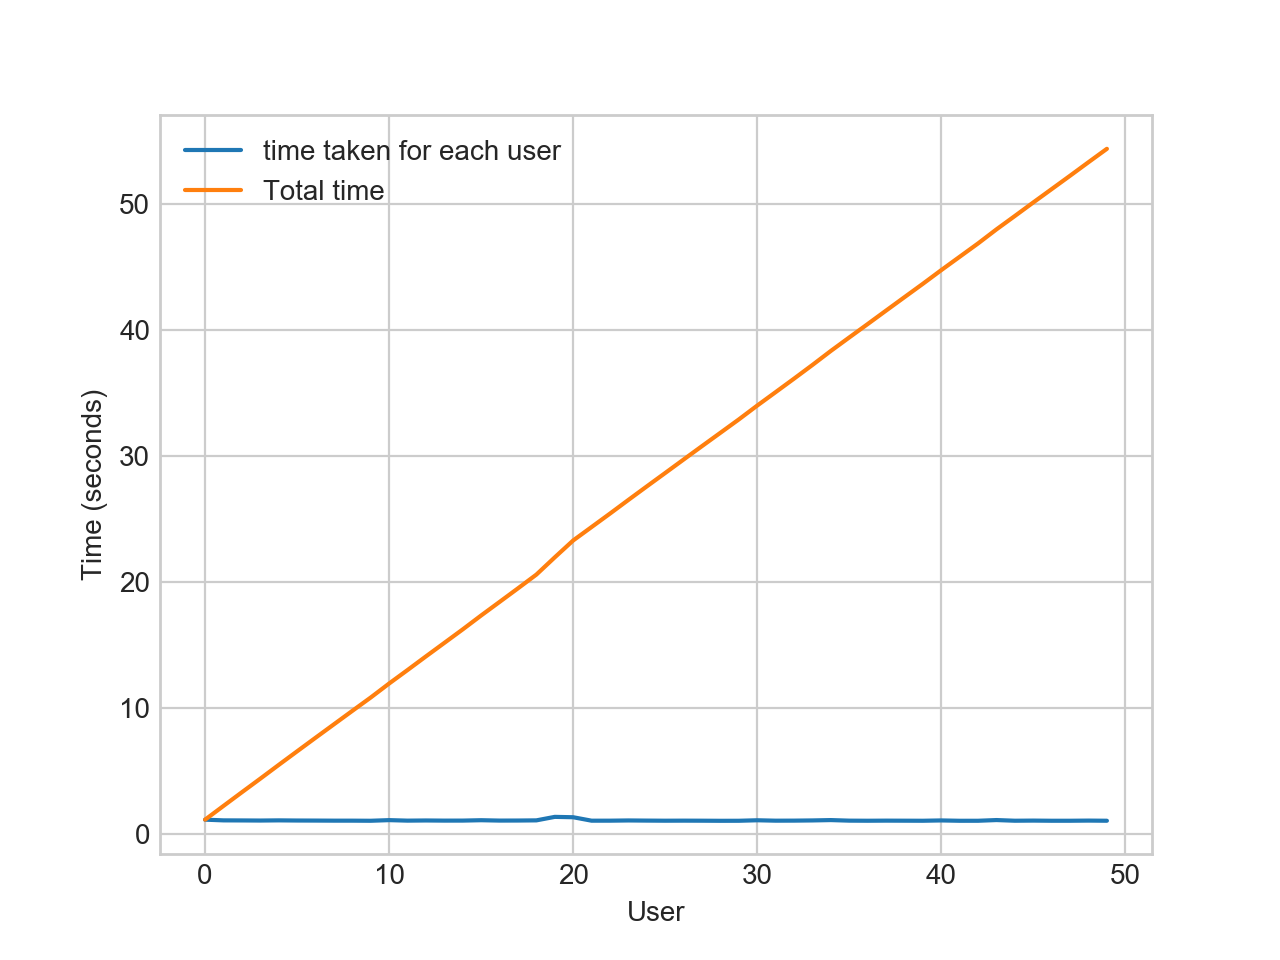

--------------------------------------------------
time: 0:00:58.870084


In [31]:
start = datetime.now()
trunc_u_u_sim_matrix, _ = compute_user_similarity(trunc_sparse_matrix, compute_for_few=True, top=50, verbose=True, 
                                                 verb_for_n_rows=10)

In [318]:
# Computing Movie-Movie Similarity matrix

start = datetime.now()
if not os.path.isfile('m_m_sim_sparse.npz'):
    start = datetime.now()
    m_m_sim_sparse = cosine_similarity(X=train_SM.T, dense_output=False)
    sparse.save_npz("m_m_sim_sparse.npz", m_m_sim_sparse)
else:
    m_m_sim_sparse = sparse.load_npz("m_m_sim_sparse.npz")

In [33]:
m_m_sim_sparse = sparse.load_npz("m_m_sim_sparse.npz")

In [34]:
m_m_sim_sparse.shape

(17771, 17771)

In [35]:
movie_ids = np.unique(m_m_sim_sparse.nonzero()[1])

In [319]:
start = datetime.now()
similar_movies = dict()
for movie in movie_ids:
    sim_movies = m_m_sim_sparse[movie].toarray().ravel().argsort()[::-1][1:]
    similar_movies[movie] = sim_movies[:100]

# just testing similar movies for movie_20
similar_movies[20]

array([ 6242,  1649,  2179, 10782,  6954, 10008,  5726, 11633, 13722,
       15087,  6581,  1091,  2887, 14337,  1477, 13257,   633, 11778,
       12268, 10888, 13606, 13306,  5964,  1533, 16132, 13376, 14878,
        5424,  5780, 10958,  9163,  5784,  9181, 12377, 14255,  2706,
       10897,  9837,  6059, 10755, 11933,  9307,  3131, 12312, 13122,
       14595, 12420,  4940,  8759,  9583, 13037, 15479, 11048,  4071,
        1214,  2055,  7687,   465,   198,  4811,  9504,  7856,  9083,
        9117, 10530,  4404,  7285,  1009,  5757, 13431,  7335,  2488,
       13368,  2611,  9816,  2704,  2515, 12444,  5752,   553,  2792,
       17191,  2587, 10477,  6745, 14605, 15937,  2373, 13733, 13719,
        6412,  8501, 14119,  6897,  8285,  6088,  4903, 16638,  4228,
       12550])

In [37]:
pd.DataFrame.from_dict(data=similar_movies, orient='index').to_csv('similar_movies.csv', header=False)

# Finding most similar movies using similarity matrix

In [38]:
movie_titles = pd.read_csv("movie_titles.csv", sep=',', header = None,
                           names=['movie_id', 'year_of_release', 'title'], verbose=True,
                      index_col = 'movie_id', encoding = "ISO-8859-1")

movie_titles.head()

Tokenization took: 6.64 ms
Type conversion took: 10.06 ms
Parser memory cleanup took: 0.01 ms


,year_of_release,title
movie_id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


In [39]:
movie_titles

,year_of_release,title
movie_id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW
6,1997.0,Sick
7,1992.0,8 Man
8,2004.0,What the #$*! Do We Know!?
9,1991.0,Class of Nuke 'Em High 2


In [321]:
mv_id = 17770

print("\nMovie ----->",movie_titles.loc[mv_id].values[1])
print("\nIt has {} Ratings.".format(train_SM[:,mv_id].getnnz()))
print("\nWe have {} movies which are similar to this movie".format(m_m_sim_sparse[:,mv_id].getnnz()))


Movie -----> Alien Hunter

It has 795 Ratings.

We have 17316 movies which are similar to this movie


In [41]:
similarities = m_m_sim_sparse[mv_id].toarray().ravel()
similar_indices = similarities.argsort()[::-1][1:]
similarities[similar_indices]
sim_indices = similarities.argsort()[::-1][1:] 

In [43]:
movie_titles.loc[sim_indices[:10]]

,year_of_release,title
movie_id,,
17768,2000.0,Epoch
10600,2003.0,Epoch: Evolution
10165,2000.0,Supernova
11897,2003.0,Silent Warnings
16759,1991.0,Eve of Destruction
16348,1998.0,The Arrival / The Arrival 2
5893,2001.0,Lost Voyage
8152,1983.0,Strange Invaders
2029,2002.0,Project Viper


# Machine Learning Models

In [327]:
def get_sample_sparse_matrix(sparse_matrix, no_users, no_movies, path):
    row_ind, col_ind, ratings = sparse.find(sparse_matrix)
    users = np.unique(row_ind)
    movies = np.unique(col_ind)
    np.random.seed(15)
    sample_users = np.random.choice(users, no_users, replace=False)
    sample_movies = np.random.choice(movies, no_movies, replace=False)
    mask = np.logical_and( np.isin(row_ind, sample_users),
                      np.isin(col_ind, sample_movies) )
    
    sample_sparse_matrix = sparse.csr_matrix((ratings[mask], (row_ind[mask], col_ind[mask])),
                                             shape=(max(sample_users)+1, max(sample_movies)+1))

    sparse.save_npz(path, sample_sparse_matrix)
    return sample_sparse_matrix

In [ ]:
#Sampling data

In [329]:
start = datetime.now()
path = "sample_train_SM.npz"
if os.path.isfile(path):
    sample_train_SM = sparse.load_npz(path)
else: 
    sample_train_SM = get_sample_sparse_matrix(train_SM, no_users=30000, no_movies=5000,path = path)


In [323]:
path = "sample_test_SM.npz"
if os.path.isfile(path):
    sample_test_SM = sparse.load_npz(path)
else:
    sample_test_SM = get_sample_sparse_matrix(test_SM, no_users=5000, no_movies=1000,
                                                 path = path)

In [189]:
sample_train_averages = dict()

In [190]:
#global average of ratings in our train set.
global_average = sample_train_SM.sum()/sample_train_SM.count_nonzero()
sample_train_averages['global'] = global_average
sample_train_averages

{'global': 3.5856325869700423}

In [191]:
sample_train_averages['user'] = get_average_ratings(sample_train_SM, of_users=True)
print('\nAverage rating of user 1515220 :',sample_train_averages['user'][1515220])


Average rating of user 1515220 : 3.941666666666667


In [192]:
sample_train_averages['movie'] =  get_average_ratings(sample_train_SM, of_users=False)
print('\n Average rating of movie 15153 :',sample_train_averages['movie'][33])


 Average rating of movie 15153 : 4.1303116147308785


In [330]:
print('\n Total number of ratings in Our Sampled train matrix is : {}\n'.format(sample_train_SM.count_nonzero()))
print('\n Total number of ratings in Our Sampled test  matrix is : {}\n'.format(sample_test_SM.count_nonzero()))


 Total number of ratings in Our Sampled train matrix is : 1763797


 Total number of ratings in Our Sampled test  matrix is : 17977



# Featurizing data for regression problem

In [194]:
sample_train_users, sample_train_movies, sample_train_ratings = sparse.find(sample_train_SM)

In [331]:
with open('reg_train.csv', mode='w') as reg_data_file:
    count = 0
    for (user, movie, rating)  in zip(sample_train_users, sample_train_movies, sample_train_ratings):
        st = datetime.now()      
        user_sim = cosine_similarity(sample_train_SM[user], sample_train_SM).ravel()
        top_sim_users = user_sim.argsort()[::-1][1:] 
        top_ratings = sample_train_SM[top_sim_users, movie].toarray().ravel()
        top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
        top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))       
        movie_sim = cosine_similarity(sample_train_SM[:,movie].T, sample_train_SM.T).ravel()
        top_sim_movies = movie_sim.argsort()[::-1][1:] 
        top_ratings = sample_train_SM[user, top_sim_movies].toarray().ravel()
        top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
        top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 

        row = list()
        row.append(user)
        row.append(movie)
        row.append(sample_train_averages['global']) 
        row.extend(top_sim_users_ratings)
        row.extend(top_sim_movies_ratings)
        row.append(sample_train_averages['user'][user])
        row.append(sample_train_averages['movie'][movie])
        row.append(rating)
        count = count + 1

        reg_data_file.write(','.join(map(str, row)))
        reg_data_file.write('\n')        

In [337]:
reg_train = pd.read_csv('reg_train.csv', names = ['user', 'movie', 'Global_Avg', 'Similar_user_1', 'Similar_user_2', 'Similar_user_3', 'Similar_user_4', 'Similar_user_5','Similar_movie_rating_1', 'Similar_movie_rating_2', 'Similar_movie_rating_3', 'Similar_movie_rating_4', 'Similar_movie_rating_5', 'User_Avg', 'Movie_Avg', 'rating'], header=None)
reg_train.head(20)

,user,movie,Global_Avg,Similar_user_1,Similar_user_2,Similar_user_3,Similar_user_4,Similar_user_5,Similar_movie_rating_1,Similar_movie_rating_2,Similar_movie_rating_3,Similar_movie_rating_4,Similar_movie_rating_5,User_Avg,Movie_Avg,rating
0,124742,5,3.585633,4.0,5.0,1.0,1.0,3.0,4.0,3.0,5.0,3.0,5.0,3.700787,4.142857,5
1,261262,5,3.585633,5.0,5.0,5.0,5.0,5.0,3.0,2.0,5.0,2.0,2.8,2.800000,4.142857,2
2,273956,5,3.585633,3.0,5.0,4.0,5.0,5.0,4.0,3.0,3.0,2.0,4.0,3.224490,4.142857,5
3,282064,5,3.585633,5.0,5.0,5.0,4.0,5.0,3.0,5.0,4.0,3.0,3.0,3.694444,4.142857,5
4,284978,5,3.585633,5.0,1.0,4.0,5.0,4.0,5.0,5.0,4.0,4.0,5.0,4.561644,4.142857,5
5,371814,5,3.585633,5.0,3.0,4.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0,4.857143,4.142857,5
6,433426,5,3.585633,5.0,5.0,5.0,4.0,5.0,3.0,4.0,3.0,4.0,3.0,3.277778,4.142857,5
7,473435,5,3.585633,5.0,5.0,3.0,5.0,5.0,4.0,4.0,4.0,5.0,5.0,3.666667,4.142857,5
8,524113,5,3.585633,4.0,1.0,3.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.144737,4.142857,5
9,526348,5,3.585633,2.0,5.0,5.0,4.0,1.0,5.0,5.0,1.0,1.0,3.0,3.000000,4.142857,5


In [197]:
sample_test_users, sample_test_movies, sample_test_ratings = sparse.find(sample_test_SM)

In [332]:
with open('reg_test.csv', mode='w') as reg_data_file:
    count = 0 
    for (user, movie, rating)  in zip(sample_test_users, sample_test_movies, sample_test_ratings):
        st = datetime.now()
        try:
            user_sim = cosine_similarity(sample_train_SM[user], sample_train_SM).ravel()
            top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            top_ratings = sample_train_SM[top_sim_users, movie].toarray().ravel()
            top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))

        except (IndexError, KeyError):
            top_sim_users_ratings.extend([sample_train_averages['global']]*(5 - len(top_sim_users_ratings)))
        except:
            
            raise
        try:
            movie_sim = cosine_similarity(sample_train_SM[:,movie].T, sample_train_SM.T).ravel()
            top_sim_movies = movie_sim.argsort()[::-1][1:] 
            top_ratings = sample_train_SM[user, top_sim_movies].toarray().ravel()
            top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
        except (IndexError, KeyError):
            top_sim_movies_ratings.extend([sample_train_averages['global']]*(5-len(top_sim_movies_ratings)))
        except :
            raise

        row = list()
        row.append(user)
        row.append(movie)
        row.append(sample_train_averages['global']) 
        row.extend(top_sim_users_ratings)
        row.extend(top_sim_movies_ratings)
        try:
            row.append(sample_train_averages['user'][user])
        except KeyError:
            row.append(sample_train_averages['global'])
        except:
            raise
        try:
            row.append(sample_train_averages['movie'][movie])
        except KeyError:
            row.append(sample_train_averages['global'])
        except:
            raise
        row.append(rating)
        count = count + 1
        reg_data_file.write(','.join(map(str, row)))

        reg_data_file.write('\n')        

In [338]:
reg_test_df = pd.read_csv('reg_test.csv', names = ['user', 'movie', 'Global_Avg', 'Similar_user_1', 'Similar_user_2', 'Similar_user_3', 'Similar_user_4', 'Similar_user_5','Similar_movie_rating_1', 'Similar_movie_rating_2', 'Similar_movie_rating_3', 'Similar_movie_rating_4', 'Similar_movie_rating_5', 'User_Avg', 'Movie_Avg', 'rating'], header=None)

reg_test_df.head(20)

,user,movie,Global_Avg,Similar_user_1,Similar_user_2,Similar_user_3,Similar_user_4,Similar_user_5,Similar_movie_rating_1,Similar_movie_rating_2,Similar_movie_rating_3,Similar_movie_rating_4,Similar_movie_rating_5,User_Avg,Movie_Avg,rating
0,808635,71,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,5
1,941866,71,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,4
2,1737912,71,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3
3,1849204,71,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,4
4,2227850,90,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,4
5,28572,111,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,1
6,117617,111,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,4
7,243739,111,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,4
8,303901,111,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3
9,310887,111,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,3.585633,4


# Data preparation for Surprise models

In [205]:
from surprise import Reader, Dataset

In [206]:
reader = Reader(rating_scale=(1,5))
train_data = Dataset.load_from_df(reg_train[['user', 'movie', 'rating']], reader)
trainset = train_data.build_full_trainset()

In [207]:
testset = list(zip(reg_test_df.user.values, reg_test_df.movie.values, reg_test_df.rating.values))
testset[:3]

[(808635, 71, 5), (941866, 71, 4), (1737912, 71, 3)]

# Applying Machine Learning models

In [339]:
models_evaluation_train = dict()
models_evaluation_test = dict()

In [209]:
def get_error_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean([ (y_true[i] - y_pred[i])**2 for i in range(len(y_pred)) ]))
    mape = np.mean(np.abs( (y_true - y_pred)/y_true )) * 100
    return rmse, mape

def run_xgboost(algo,  x_train, y_train, x_test, y_test):
    train_results = dict()
    test_results = dict()
    start =datetime.now()
    algo.fit(x_train, y_train, eval_metric = 'rmse')
    
    start =datetime.now()
    y_train_pred = algo.predict(x_train)
    rmse_train, mape_train = get_error_metrics(y_train.values, y_train_pred)
    
    train_results = {'rmse': rmse_train,
                    'mape' : mape_train,
                    'predictions' : y_train_pred}
    
    y_test_pred = algo.predict(x_test) 
    rmse_test, mape_test = get_error_metrics(y_true=y_test.values, y_pred=y_test_pred)
    
    test_results = {'rmse': rmse_test,
                    'mape' : mape_test,
                    'predictions':y_test_pred}
    
    return train_results, test_results

In [341]:
my_seed = 15
random.seed(my_seed)
np.random.seed(my_seed)

def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    pred = np.array([pred.est for pred in predictions])
    
    return actual, pred

def get_errors(predictions, print_them=False):

    actual, pred = get_ratings(predictions)
    rmse = np.sqrt(np.mean((pred - actual)**2))
    mape = np.mean(np.abs(pred - actual)/actual)

    return rmse, mape*100

In [210]:
def run_surprise(algo, trainset, testset, verbose=True): 
    
    start = datetime.now()
    train = dict()
    test = dict()
    
    st = datetime.now()
    algo.fit(trainset)
    st = datetime.now()
    train_preds = algo.test(trainset.build_testset())
    train_actual_ratings, train_pred_ratings = get_ratings(train_preds)
    train_rmse, train_mape = get_errors(train_preds)
    train['rmse'] = train_rmse
    train['mape'] = train_mape
    train['predictions'] = train_pred_ratings
    st = datetime.now()
    test_preds = algo.test(testset)
    test_actual_ratings, test_pred_ratings = get_ratings(test_preds)
    test_rmse, test_mape = get_errors(test_preds)    
    test['rmse'] = test_rmse
    test['mape'] = test_mape
    test['predictions'] = test_pred_ratings
    
    return train, test

In [351]:
#1. XGBoost 

import xgboost as xgb
from sklearn.model_selection import GridSearchCV

x_train = reg_train.drop(['user','movie','rating'], axis=1)
y_train = reg_train['rating']

x_train = x_train.iloc[:5000,:]
y_train = y_train.iloc[:5000,]

x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

param_dict={'n_estimators':[20,40,60,80,100,120,140,160,180,200,220,240,260],
           'max_depth':[3,6,9,12,15,18,21,24,27,30]}


first_xgb = xgb.XGBRegressor(silent=False, n_jobs=-1, random_state=15)
xb_1 = GridSearchCV(first_xgb,param_grid=param_dict)
xb_1.fit(x_train,y_train)
train_results, test_results = run_xgboost(xb_1.best_estimator_, x_train, y_train, x_test, y_test)

models_evaluation_train['XGBoost'] = train_results
models_evaluation_test['XGBoost'] = test_results

In [239]:
# .shape
# y_train.iloc[:5000,]

(5000,)

In [349]:
models_evaluation_train['XGBoost']['rmse']

0.8176589561230627

In [350]:
models_evaluation_test['XGBoost']['rmse']

1.0369382112216288

In [353]:
# 2. Suprise BaselineModel


from surprise import BaselineOnly

bsl_options={'learning_rate':0.01,'method':'sgd'}
bsl_train_results, bsl_test_results = run_surprise(BaselineOnly(bsl_options=bsl_options), trainset, testset, verbose=True)
models_evaluation_train['Baseline'] = bsl_train_results 
models_evaluation_test['Baseline'] = bsl_test_results

In [354]:
models_evaluation_train['Baseline']['rmse']

0.8644378859768737

In [356]:
models_evaluation_test['Baseline']['rmse']

1.0317612416925925

In [357]:
# 3. XGBoost + Surprise Baseline predictor

In [362]:
from sklearn.model_selection import GridSearchCV
x_train = reg_train.drop(['user', 'movie','rating'], axis=1)
y_train = reg_train['rating']

x_train = x_train.iloc[:500,:]
y_train = y_train.iloc[:500,]

x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

param_dict={'n_estimators':[20,40,60,80,100,140,180,220]}
xgb_bsl = xgb.XGBRegressor(silent=False, n_jobs=-1, random_state=15)
xb_2 = GridSearchCV(xgb_bsl,param_grid=param_dict)
xb_2.fit(x_train,y_train)
train_results, test_results = run_xgboost(xb_2.best_estimator_, x_train, y_train, x_test, y_test)
models_evaluation_train['XGBoost & Baseline'] = train_results
models_evaluation_test['XGBoost & Baseline'] = test_results

In [359]:
models_evaluation_train['XGBoost & Baseline']['rmse']

0.7255689749256988

In [361]:
models_evaluation_test['XGBoost & Baseline']['rmse']

1.035660164557661

In [363]:
# 4. Surprise KNNBaseline predictor

from surprise import KNNBaseline

In [367]:
param_dict ={'sim_options':{'shrinkage':[100],
                            'min_support': [2]},
             'bsl_options':{'method':['sgd']                           
                           },
             'k':[60]
             }
knn_bsl_u = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)
knn_bsl_u_train_results, knn_bsl_u_test_results = run_surprise(knn_bsl_u,trainset, testset, verbose=True)
models_evaluation_train['KNN_Baseline_User'] = knn_bsl_u_train_results 
models_evaluation_test['KNN_Baseline_User'] = knn_bsl_u_test_results

In [365]:
models_evaluation_train['KNN_Baseline_User']['rmse']

0.2545323777170009

In [366]:
models_evaluation_test['KNN_Baseline_User']['rmse']

1.0324355717119171

In [368]:
# 4.2 Surprise KNNBaseline with movie movie similarities

In [372]:
knn = KNNBaseline(sim_options={'shrinkage':100,'min_support':2,'user_base':False},bsl_options={'method':'sgd'},k=60)
knn_bsl_m_train_results, knn_bsl_m_test_results = run_surprise(knn,trainset, testset, verbose=True)

models_evaluation_train['KNN_Baseline_Movie'] = knn_bsl_m_train_results 
models_evaluation_test['KNN_Baseline_Movie'] = knn_bsl_m_test_results

In [370]:
models_evaluation_train['KNN_Baseline_Movie']['rmse']

0.4011928185833364

In [371]:
models_evaluation_test['KNN_Baseline_Movie']['rmse']

1.0314692695886736

In [373]:
#5. SVD - matrix factorization

In [374]:
from surprise import SVD

In [378]:
svd_train_results, svd_test_results = run_surprise(SVD(n_factors=20), trainset, testset, verbose=True)
models_evaluation_train['SVD'] = svd_train_results 
models_evaluation_test['SVD'] = svd_test_results

In [376]:
models_evaluation_train['SVD']['rmse']

0.8163475520916272

In [377]:
models_evaluation_test['SVD']['rmse']

1.0313664825900142

In [380]:
pd.DataFrame(models_evaluation_test).loc['rmse'].sort_values()

SVD                   1.03137
KNN_Baseline_Movie    1.03147
Baseline              1.03176
KNN_Baseline_User     1.03244
XGBoost & Baseline    1.03566
XGBoost               1.03694
Name: rmse, dtype: object

# Anvil Application

In [283]:
def testbyID(mv_id):
    similarities = m_m_sim_sparse[mv_id].toarray().ravel()
    similar_indices = similarities.argsort()[::-1][1:]
    similarities[similar_indices]
    sim_indices = similarities.argsort()[::-1][1:] 
    return movie_titles.loc[sim_indices[:10]]

In [284]:
import anvil.server

anvil.server.connect("U5634CEZX2FSZLJYYZUVRYCP-WEURMYVPG5HS3S5F")
from anvil.tables import app_tables

@anvil.server.callable
def say_hello(search):
#     table = test(17770)
    if search == '*':
        table = movie_titles
    else:
        table = movie_titles[movie_titles['title'].str.contains(search, case=False)]
    return list(table.T.to_dict().values())

@anvil.server.callable
def recommendName(search):
    id = movie_titles[movie_titles['title']==search]
    id = id.index.values[0]
    table = test(id)
    return list(table.T.to_dict().values())

anvil.server.wait_forever()

KeyboardInterrupt: 